In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '307002',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/C9U2E51tkzLljewFEGQ74g__thumb/img/4KV3wj3NiJDgGTh3zmW0_8Ph3Zc=/fit-in/200x150/filters:strip_icc()/pic5837347.jpg',
  'name': 'Regicide',
  'yearpublished': '2020'},
 {'id': '342444',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/cwQZOU3cNOTta6nuT77byg__thumb/img/ktq00DLZxfyjPhrAvHe-V48i-Kg=/fit-in/200x150/filters:strip_icc()/pic6279361.png',
  'name': 'Black Rose Wars: Rebirth',
  'yearpublished': '2022'}]

In [6]:
def get_game_by_id(game_id, field='name'):
    for a in hot_array:
        if a['id'] == str(game_id):
            return a[field]

In [7]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,307002,AgentMeat,2.0,"only solo, played with normal deck of cards, s..."
1,307002,Akuden,8.0,Kickstarted. Tried out the game solo and at 2 ...
2,307002,amqueue,N/A,kickstarter
3,307002,andrewkapish,N/A,Unplayed
4,307002,Angelo the Magician,9.0,I only play the solo version and that one is ...
...,...,...,...,...
119035,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
119036,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
119037,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
119038,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [8]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [9]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 19146 for 'remove_short_comments' - min len: 25 - method: unrated


In [10]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [11]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9.0        18666
10.0       18294
8.0        16497
7.0         8842
N/A         8025
           ...  
9.245          1
2.4            1
8.43312        1
9.337          1
8.26667        1
Name: rating, Length: 605, dtype: int64

In [12]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(91869, 5)

In [13]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(8025, 5)

## CREATE TRAINING AND VALIDATION DATA

In [14]:
# use rated comments (reviews) to train the model

In [15]:
rated_comments = rated_comments.sample(frac=1)

In [16]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [17]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'This is the poster child for not complex, but deep gameplay. Very strategic, very engaging an very much fun. Rules explanation is done in a breeze. Gameplay flows around the table: play a card, do the actions.  Artwork and implementation of theme are subpar, but in the end irrelevant with such a perfect game.'

In [18]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Meh ... '

## COMPOSE MODEL

In [19]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [20]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
45/45 - 5s - loss: 0.5537 - accuracy: 0.7890 - val_loss: 0.4848 - val_accuracy: 0.8438
Epoch 2/100
45/45 - 2s - loss: 0.4207 - accuracy: 0.8510 - val_loss: 0.3894 - val_accuracy: 0.8499
Epoch 3/100
45/45 - 2s - loss: 0.3366 - accuracy: 0.8667 - val_loss: 0.3471 - val_accuracy: 0.8610
Epoch 4/100
45/45 - 2s - loss: 0.2906 - accuracy: 0.8870 - val_loss: 0.3301 - val_accuracy: 0.8681
Epoch 5/100
45/45 - 2s - loss: 0.2584 - accuracy: 0.8994 - val_loss: 0.3260 - val_accuracy: 0.8698
Epoch 6/100
45/45 - 2s - loss: 0.2330 - accuracy: 0.9103 - val_loss: 0.3285 - val_accuracy: 0.8701
Epoch 7/100
45/45 - 2s - loss: 0.2116 - accuracy: 0.9192 - val_loss: 0.3356 - val_accuracy: 0.8687
Epoch 8/100
45/45 - 2s - loss: 0.1931 - accuracy: 0.9279 - val_loss: 0.3453 - val_accuracy: 0.8655
Epoch 9/100
45/45 - 2s - loss: 0.1774 - accuracy: 0.9347 - val_loss: 0.3555 - val_accuracy: 0.8629
Epoch 10/100
45/45 - 2s - loss: 0.1637 - accuracy: 0.9397 - val_loss: 0.3716 - val_accuracy: 0.8614
30/30 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002408EF677C0>,
             param_grid={})

In [21]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [22]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [24]:
epochs = range(1, len(acc) + 1) 

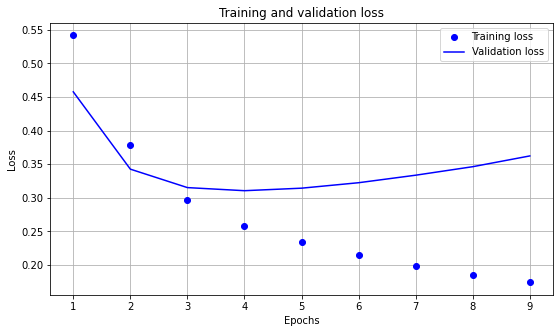

In [25]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

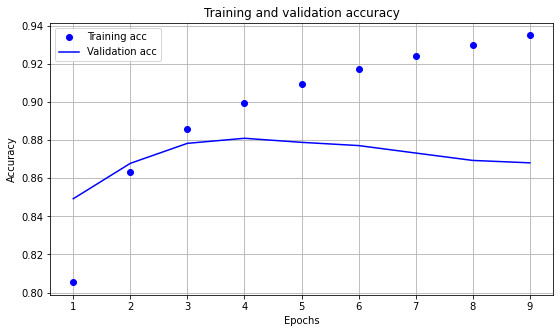

In [26]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [27]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"This is the poster child for not complex, but deep gameplay. Very strategic, very engaging an very much fun. Rules explanation is done in a breeze. Gameplay flows around the table: play a card, do the actions.  Artwork and implementation of theme are subpar, but in the end irrelevant with such a perfect game."
score: 1.000000
actual: 1

input:
"Meh ... "
score: 0.000000
actual: 0

input:
"Still have to play it more. Reading about the grinding aspect lost my interest a bit, so just dropped from a 9 to an 8."
score: 1.000000
actual: 1

input:
"Alternative to splendor, easy to teach. I would play Quacks at 4 players since it scales really well with more players. Upgraded bits from BGG is nice. "
score: 1.000000
actual: 1

input:
"Too long and too much downtime which made me feel so bored. The game would be good if its flow is better."
score: 0.000000
actual: 0

input:
"We mostly like this one. The story aspects are interesting and it's mechanically fun (which is more than I can sa

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [28]:
## APPLY MODEL ON NON-RATED COMMENTS

In [29]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Probably too long/heavy to own but want to play based on JGG review."
score: 1.000000

input:
"Agata Freindorf & Mateusz Szczepaniak"
score: 1.000000

input:
"Otro juego del que debía haberme informado más antes de comprarlo. Ya odiaba el Terra Mystica antes de saber de éste. ¿Cómo no lo vi venir? Sería el hype, porque lo tenía marcado en la lista de deseos como «no comprar».  Seguro que mecánicamente es la pera, no lo dudo, por eso no lo voy a puntuar aún, hasta que lo pruebe, pero vamos... un juego del espacio, donde tienes 14 razas diferentes (una cosa que no me gusta mucho de por sí, salvo que tenga un trasfondo medio lógico/currado, que según he leído no lo hay) y en el que hay una expansión pacífica... ¡venga ya! ¿Qué es? ¿un 3x? Exploración, explotación y expansión. ¿Qué pasa con la exterminación? Si es ahí donde está lo bueno de los juegos del espacio en las tortas por todas partes. Puedo soportar los multisolitarios si el tema acompaña, pero en estas circunsta

## REGRESSOR

In [30]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000240B0FA1730>,
             param_grid={})

In [31]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [32]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [33]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [34]:
epochs = range(1, len(mean_squared_error) + 1) 

In [35]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.41


In [36]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 0.93


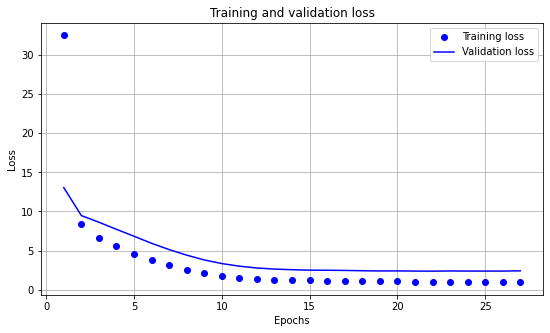

In [37]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

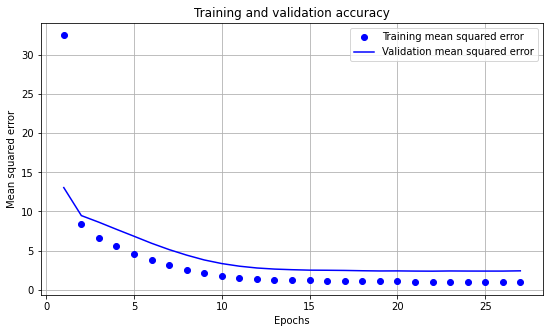

In [38]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [39]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"This is the poster child for not complex, but deep gameplay. Very strategic, very engaging an very much fun. Rules explanation is done in a breeze. Gameplay flows around the table: play a card, do the actions.  Artwork and implementation of theme are subpar, but in the end irrelevant with such a perfect game."
score: 8.32
actual: 9.00 

input: 
"Meh ... "
score: 6.05
actual: 6.50 

input: 
"Still have to play it more. Reading about the grinding aspect lost my interest a bit, so just dropped from a 9 to an 8."
score: 6.28
actual: 8.00 

input: 
"Alternative to splendor, easy to teach. I would play Quacks at 4 players since it scales really well with more players. Upgraded bits from BGG is nice. "
score: 7.10
actual: 7.00 

input: 
"Too long and too much downtime which made me feel so bored. The game would be good if its flow is better."
score: 6.83
actual: 6.00 

input: 
"We mostly like this one. The story aspects are interesting and it's mechanically fun (which is more than I 

## COMPARE CLASSIFIER VS REGRESSOR

In [40]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Similar to Caylus in regard to expanding board which can be used by all players"
    reg score: 9.79
    clf score: 1

"All content available thus far through Undimensioned and Unseen"
    reg score: 6.81
    clf score: 1

"2nd edition Kickstarter supporter. Won't ship for some time."
    reg score: 8.35
    clf score: 1

"Picked up this past weekend looking at starting next week."
    reg score: 9.18
    clf score: 1

"Gekk up bits 3d printed organizer"
    reg score: 8.92
    clf score: 1

"Gestion de ressources. Version solo disponible :)"
    reg score: 11.10
    clf score: 1

"This is one of the best LOTR games on the market today, even after its release 10 years ago it in my mind stands as a true masterpiece.  Just doesn't get to the table often enough, but when it does it plays like a highlight real from the books / films. "
    reg score: 10.07
    clf score: 1

"Probably the heaviest game I own. We set it up with a friend and watched a couple How to Play videos, then played s

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [41]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 115746.00 |          8.74 |        1948.00 |
| 121921.00 |          7.74 |        4525.00 |
| 124361.00 |          8.19 |        3971.00 |
| 162886.00 |          8.37 |        3723.00 |
| 167355.00 |          8.41 |        2026.00 |


In [42]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [43]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 115746.00 |          8.34 |         266.00 |
| 121921.00 |          8.08 |         462.00 |
| 124361.00 |          8.14 |         259.00 |
| 162886.00 |          8.08 |         328.00 |
| 167355.00 |          8.42 |         215.00 |


In [44]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [45]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/C9U2E51...","<a href=""https://boardgamegeek.com/boardgame/3...",8.005169,8.263270,8.026677,1,2020
1,"<img src=""https://cf.geekdo-images.com/cwQZOU3...","<a href=""https://boardgamegeek.com/boardgame/3...",9.600000,9.048062,9.354694,2,2022
2,"<img src=""https://cf.geekdo-images.com/hItZjdD...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.362697,8.635581,3,2022
3,"<img src=""https://cf.geekdo-images.com/_al0scM...","<a href=""https://boardgamegeek.com/boardgame/2...",7.499910,8.377569,7.716360,4,2021
4,"<img src=""https://cf.geekdo-images.com/Q96PxRV...","<a href=""https://boardgamegeek.com/boardgame/3...",7.168810,6.681438,7.145338,5,2021


In [46]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [47]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Regicide,8.005169,8.263270,8.026677,1,2020
2,,Black Rose Wars: Rebirth,9.600000,9.048062,9.354694,2,2022
3,,Voidfall,10.000000,8.362697,8.635581,3,2022
4,,Ankh: Gods of Egypt,7.499910,8.377569,7.716360,4,2021
5,,Descent: Legends of the Dark,7.168810,6.681438,7.145338,5,2021


In [48]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.362697,8.635581,3,2022
2,,Mythic Mischief,9.600000,7.457655,8.647847,17,2022
3,,Black Rose Wars: Rebirth,9.600000,9.048062,9.354694,2,2022
4,,Eclipse: Second Dawn for the Galaxy,8.740709,8.124405,8.648941,42,2020
5,,War of the Ring: Second Edition,8.735036,8.336409,8.687144,43,2012


In [49]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Black Rose Wars: Rebirth,9.600000,9.048062,9.354694,2,2022
2,,War of the Ring: Second Edition,8.735036,8.336409,8.687144,43,2012
3,,Eclipse: Second Dawn for the Galaxy,8.740709,8.124405,8.648941,42,2020
4,,Mythic Mischief,9.600000,7.457655,8.647847,17,2022
5,,Brass: Birmingham,8.678102,8.197351,8.636093,24,2018


In [50]:
# model.save('saved_model\my_model')

In [51]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [52]:
# some examples on "long" comments vs short comments

In [53]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [54]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\" ({get_game_by_id(c['id'])}) \nscore: {c['rating']:.2f}\n"), axis=1);

"has a little bit of everything, can be played solo or up to 4 players. push your luck, worker placement. good ratings. game weighs 10 lbs probably" (A Feast for Odin) 
score: 6.47

"Got my quasi-kickstarter game today! (December 9, 2015). Can't wait to play!  Another one that I seem to like more than my group. Will have to try this with more players (can be a bit brutal with two, it seems).  Update 03-2018: Vinhos just straight up fired this game." (Viticulture Essential Edition) 
score: 7.11

"Appealing as Euros go, plenty of options, fun theme, good level of complexity.  Engine building sometimes gives a similar vibe to Race for the Galaxy.  Reuben has.  I'd probably rate 7.5.  Ugly art.  Get on IOS when it comes out." (Terraforming Mars) 
score: 7.13

"Dice Tower, Sam Healey's Top 100 Games of All Time 2017, #2;  3 Minutes Board Game, Top 100 Games of All Time, #55;  GameTrollTV, Najlepsza 50 Gier 2017, #18;" (Twilight Imperium: Fourth Edition) 
score: 7.25

"Its cleverness is shoc

## RANDOM FOREST - TEST

In [55]:
# no support for Windows at the moment - waiting for it to test